In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import socket
import sys

sys.path.append("../bayesian_trees")

In [3]:
RUN_MODE = 'LOCAL'

if 'gdpic-srvls-session' in socket.gethostname():
    RUN_MODE = 'ServerlessSession'
    
print(f"Run mode is {RUN_MODE}")

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

if RUN_MODE == 'LOCAL':
    JAVA_VER = "11.0.22+7"
    JAVA_FOLDER = "/tmp/java"
    FILE_NAME = f"openlogic-openjdk-{JAVA_VER}-linux-x64"
    TAR_FILE = f"{JAVA_FOLDER}/{FILE_NAME}.tar.gz"
    DOWNLOAD_LINK = f"https://builds.openlogic.com/downloadJDK/openlogic-openjdk/{JAVA_VER}/openlogic-openjdk-{JAVA_VER}-linux-x64.tar.gz"
    PYSPARK_VER = "3.3.2"

    ! rm -rf $JAVA_FOLDER && mkdir -p $JAVA_FOLDER
    ! wget -q -P $JAVA_FOLDER $DOWNLOAD_LINK
    os.environ["JAVA_HOME"] = f"{JAVA_FOLDER}/{FILE_NAME}"
    ! tar -zxf $TAR_FILE -C $JAVA_FOLDER
    ! echo $JAVA_HOME

    # Pin the Spark version to match that the Dataproc 2.1 cluster.
    ! pip install pyspark==$PYSPARK_VER -q
    
    ! rm -rf /tmp/jars && mkdir -p /tmp/jars
    ! wget -q -P /tmp/jars https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.15/gcs-connector-hadoop3-2.2.15-shaded.jar
    ! ls -l /tmp/jars

Run mode is LOCAL
/tmp/java/openlogic-openjdk-11.0.22+7-linux-x64
total 37120
-rw-r--r-- 1 jupyter jupyter 38009441 Jun  1  2023 gcs-connector-hadoop3-2.2.15-shaded.jar


In [4]:
import logging

import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

from adabooster import AdaBooster
from bayesian_tree import BayesianTree
from gradient_booster import GradientBooster
from random_forest import RandomForest
from sigmoid_calibrator import SigmoidCalibrator
from tree_utils import get_log_loss, plot_performance_chart

pd.DataFrame.iteritems = pd.DataFrame.items

logger = logging.getLogger(__name__)
logging_formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logging_file_handler = logging.FileHandler(filename="classification_adult_census.log")
logging_console_handler = logging.StreamHandler()
logging_file_handler.setFormatter(logging_formatter)
logging_console_handler.setFormatter(logging_formatter)
logging.basicConfig(handlers=[logging_console_handler, logging_file_handler], level=logging.INFO)

In [5]:
spark_builder = SparkSession.builder.appName("classification_adult_cencus")

if RUN_MODE == 'LOCAL':
    spark_builder = (
        spark_builder
        .config("spark.jars", "/tmp/jars/gcs-connector-hadoop3-2.2.15-shaded.jar")
        .config("spark.driver.memory", "2g")
        .config("spark.executor.memory", "2g")
        .config("spark.sql.shuffle.partitions", "4000")
    )
else:
    spark_builder = (
        spark_builder
        .config("spark.sql.hive.filesourcePartitionFileCacheSize", "524288000")
    )

spark = (
    spark_builder
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")
logger.info(f"Spark Version: {sc.version}")

24/10/10 14:16:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-10-10 14:16:52,076 - __main__ - INFO - Spark Version: 3.3.2


In [6]:
LEARN_DATA_FILE = "../datasets/adult_census_income/adult.data"
TEST_DATA_FILE = "../datasets/adult_census_income/adult.test"

RAW_DATA_COLS = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]
RAW_DATA_NUMERIC_COLS = [
    "age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"
]

OUTCOMES_COLS = ["negative", "positive"]

In [7]:
raw_learn_data = pd.read_csv(
    LEARN_DATA_FILE, 
    sep=", ", 
    header=None, 
    na_values=["?"], 
    names=RAW_DATA_COLS,
    engine="python"
)
raw_learn_data["negative"] = np.where(raw_learn_data["income"] == "<=50K", 1, 0)
raw_learn_data["positive"] = np.where(raw_learn_data["income"] == ">50K", 1, 0)
raw_learn_data.drop(columns=(["income"] + RAW_DATA_NUMERIC_COLS), inplace=True)
logger.info(f"Raw Learning Set Shape: {raw_learn_data.shape}")

raw_test_data = pd.read_csv(
    TEST_DATA_FILE, 
    sep=", ", 
    header=None, 
    skiprows=1, 
    na_values=["?"], 
    names=RAW_DATA_COLS, 
    engine="python"
)
raw_test_data["negative"] = np.where(raw_test_data["income"] == "<=50K.", 1, 0)
raw_test_data["positive"] = np.where(raw_test_data["income"] == ">50K.", 1, 0)
raw_test_data.drop(columns=(["income"] + RAW_DATA_NUMERIC_COLS), inplace=True)
logger.info(f"Raw Testing Set Shape: {raw_test_data.shape}")

logger.info("Raw Learning Set Stats:")
for c in raw_learn_data.columns:
    logger.info(
        f"{c}: {raw_learn_data[c].dtype} {len(raw_learn_data[c].unique())}"
        f" {raw_learn_data[c].isnull().sum()}"
    )
    
PREDICTORS = [c for c in raw_learn_data.columns if c not in OUTCOMES_COLS]

2024-10-10 14:16:52,554 - __main__ - INFO - Raw Learning Set Shape: (32561, 10)
2024-10-10 14:16:52,730 - __main__ - INFO - Raw Testing Set Shape: (16281, 10)
2024-10-10 14:16:52,731 - __main__ - INFO - Raw Learning Set Stats:
2024-10-10 14:16:52,738 - __main__ - INFO - workclass: object 9 1836
2024-10-10 14:16:52,746 - __main__ - INFO - education: object 16 0
2024-10-10 14:16:52,751 - __main__ - INFO - marital-status: object 7 0
2024-10-10 14:16:52,755 - __main__ - INFO - occupation: object 15 1843
2024-10-10 14:16:52,761 - __main__ - INFO - relationship: object 6 0
2024-10-10 14:16:52,766 - __main__ - INFO - race: object 5 0
2024-10-10 14:16:52,770 - __main__ - INFO - sex: object 2 0
2024-10-10 14:16:52,774 - __main__ - INFO - native-country: object 42 583
2024-10-10 14:16:52,778 - __main__ - INFO - negative: int64 2 0
2024-10-10 14:16:52,780 - __main__ - INFO - positive: int64 2 0


In [8]:
learn_data = raw_learn_data
test_data = raw_test_data

2024-10-10 06:46:13,650 - __main__ - INFO - DONE.
2024-10-10 06:46:13,964 - __main__ - INFO - Log-Loss: 0.3674


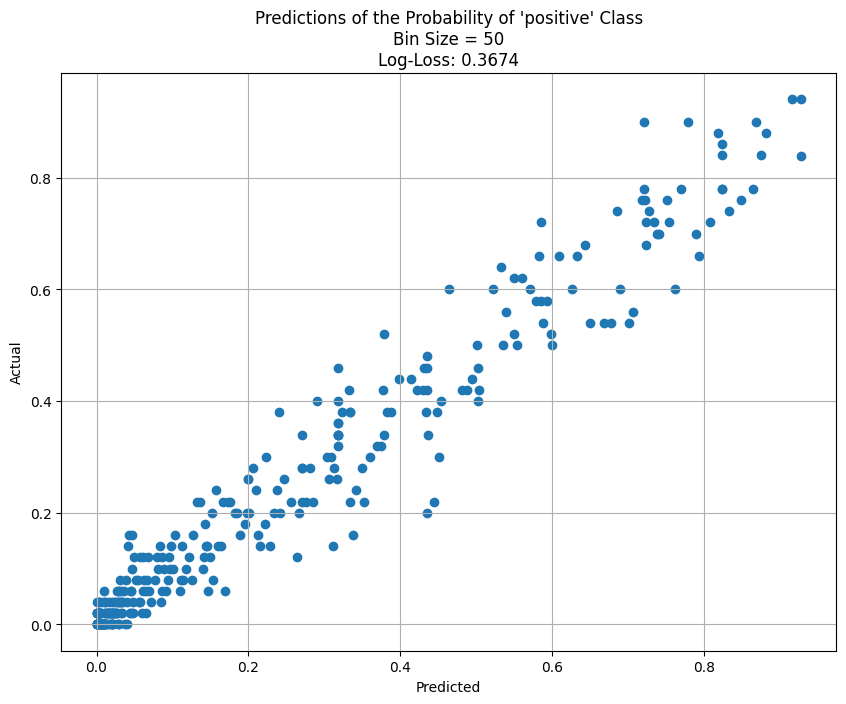

In [12]:
model_kwargs = {
    "split_method": "gain",
    "prior_method": "mle",
    "prior_alpha": [1.0, 1.0],
    "prior_cap": 100,
    "min_smooth_obs": 100,
    "min_prediction": 1e-6,
    "min_improvement": 1e-6,
    "write_log": False
}
model = BayesianTree(**model_kwargs)
model.fit(X=learn_data[PREDICTORS], y=learn_data[OUTCOMES_COLS])
logger.info("DONE.")

predictions = model.predict_proba(test_data[PREDICTORS]) 
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 06:46:29,084 - __main__ - INFO - DONE.
2024-10-10 06:46:29,557 - __main__ - INFO - Log-Loss: 0.3674


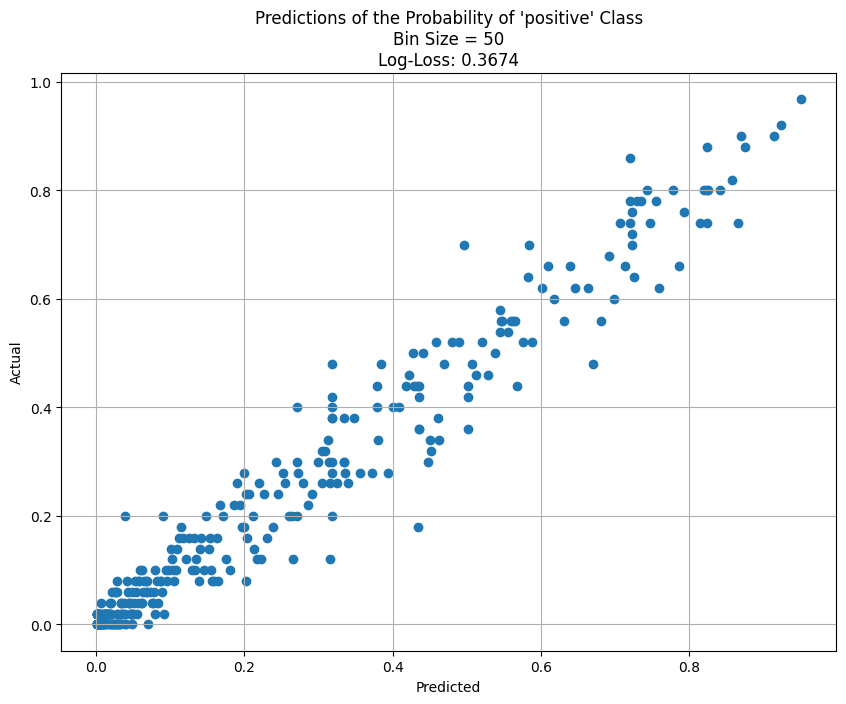

In [13]:
model_kwargs = {
    "split_method": "gain",
    "prior_method": "counting",
    "prior_alpha": [1.0, 1.0],
    "prior_cap": 100,
    "min_smooth_obs": None,
    "min_prediction": 1e-6,
    "min_improvement": 1e-6,
    "write_log": False
}
model = BayesianTree(**model_kwargs)
model.fit(X=learn_data[PREDICTORS], y=learn_data[OUTCOMES_COLS])
logger.info("DONE.")

predictions = model.predict_proba(test_data[PREDICTORS]) 
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 06:46:43,525 - random_forest - INFO - Building tree #0...
2024-10-10 06:46:48,560 - random_forest - INFO - Training Log-Loss: 0.3702
2024-10-10 06:46:48,561 - random_forest - INFO - Building tree #1...
2024-10-10 06:46:55,844 - random_forest - INFO - Training Log-Loss: 0.3627
2024-10-10 06:46:55,845 - random_forest - INFO - Building tree #2...
2024-10-10 06:47:03,186 - random_forest - INFO - Training Log-Loss: 0.3805
2024-10-10 06:47:03,188 - random_forest - INFO - Building tree #3...
2024-10-10 06:47:09,314 - random_forest - INFO - Training Log-Loss: 0.3788
2024-10-10 06:47:09,315 - random_forest - INFO - Building tree #4...
2024-10-10 06:47:16,872 - random_forest - INFO - Training Log-Loss: 0.3594
2024-10-10 06:47:16,873 - random_forest - INFO - Building tree #5...
2024-10-10 06:47:25,757 - random_forest - INFO - Training Log-Loss: 0.3802
2024-10-10 06:47:25,759 - random_forest - INFO - Building tree #6...
2024-10-10 06:47:36,620 - random_forest - INFO - Training Log-Loss:

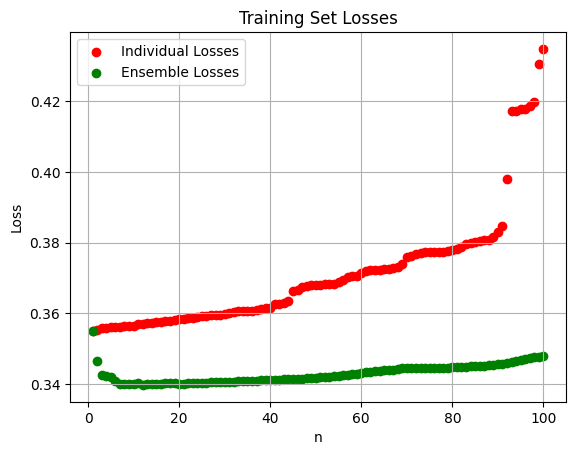

2024-10-10 07:00:48,112 - random_forest - INFO - Losses:
      n  individual_losses  ensemble_losses
0     1           0.392742         0.392742
1     2           0.390197         0.382928
2     3           0.395329         0.379558
3     4           0.389736         0.378107
4     5           0.387508         0.377259
5     6           0.394168         0.376013
6     7           0.396913         0.376081
7     8           0.394506         0.376258
8     9           0.391905         0.376161
9    10           0.395677         0.375886
10   11           0.388598         0.375446
11   12           0.394298         0.374963
12   13           0.393210         0.375076
13   14           0.388450         0.374873
14   15           0.391209         0.374737
15   16           0.392201         0.374652
16   17           0.391613         0.374625
17   18           0.394540         0.374588
18   19           0.387903         0.374328
19   20           0.396159         0.374192
20   21           0

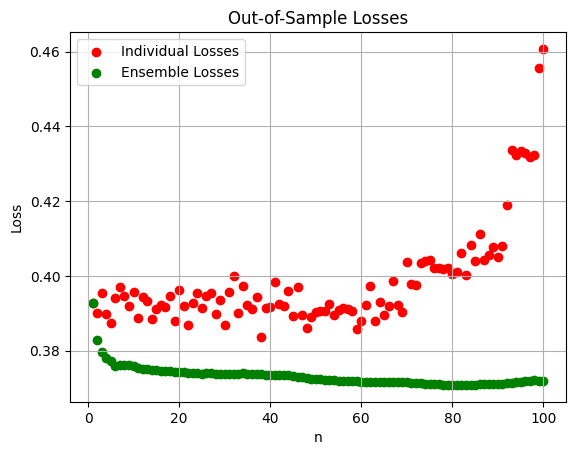

2024-10-10 07:00:48,353 - __main__ - INFO - Optimized number of trees: 81
2024-10-10 07:01:18,314 - random_forest - INFO - Losses:
      n  individual_losses  ensemble_losses
0     1           0.378836         0.378836
1     2           0.380608         0.370270
2     3           0.380598         0.365832
3     4           0.377016         0.364764
4     5           0.375420         0.364189
5     6           0.384276         0.363592
6     7           0.379094         0.363159
7     8           0.383983         0.363213
8     9           0.380425         0.363221
9    10           0.382397         0.363152
10   11           0.379173         0.362955
11   12           0.384658         0.362583
12   13           0.380155         0.362633
13   14           0.378733         0.362604
14   15           0.383893         0.362746
15   16           0.378314         0.362684
16   17           0.376479         0.362511
17   18           0.381465         0.362440
18   19           0.379523       

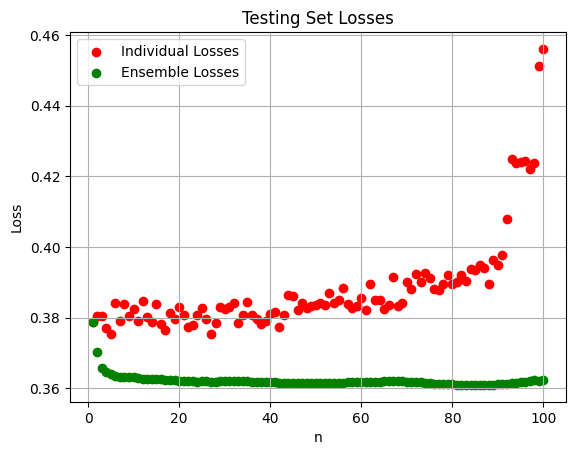

2024-10-10 07:01:40,840 - __main__ - INFO - Log-Loss: 0.3611


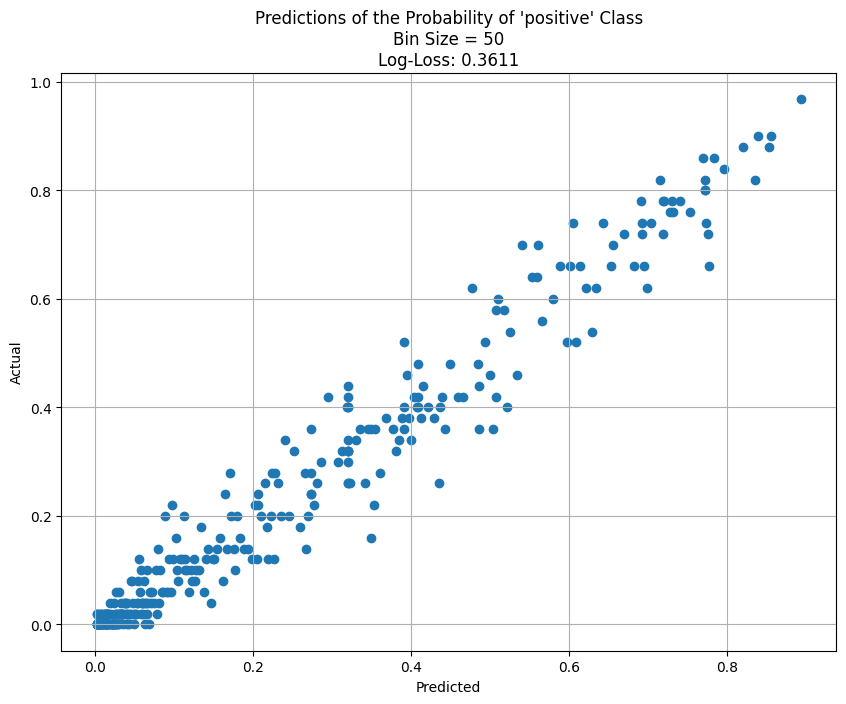

In [ ]:
n_trees = 100
oos_frac = 0.2

tree_kwargs = {
    "split_method": "gain",
    "prior_method": "mle",
    "prior_alpha": [1.0, 1.0],
    "prior_cap": 100,
    "min_smooth_obs": 100,
    "min_prediction": 1e-6,
    "min_improvement": 1e-6,
    "max_level": None,
    "predictors_to_ignore": 0.3,
    "write_log": False
}
forest_kwargs = {
    "n_trees": n_trees, 
    "predictors_to_remove": 0.3, 
    "sampling_frac": 0.7, 
    "random_state": 1234,     
}

train_ind = np.random.choice(
    learn_data.shape[0], 
    round((1.0 - oos_frac) * learn_data.shape[0]), 
    replace=False
)

train_data = learn_data.loc[train_ind, :]
train_data.reset_index(drop=True, inplace=True)
oos_data = learn_data.loc[~learn_data.index.isin(train_ind), :]
oos_data.reset_index(drop=True, inplace=True)

random_forest = RandomForest(**{**forest_kwargs, **tree_kwargs})
random_forest.fit(X=train_data[PREDICTORS], y=train_data[OUTCOMES_COLS])

random_forest.plot_losses(X=None)
oss_loss_data  = random_forest.plot_losses(
    X=oos_data[PREDICTORS], y=oos_data[OUTCOMES_COLS], title="Out-of-Sample Losses"
)

opt_n_trees = oss_loss_data.loc[oss_loss_data["ensemble_losses"].idxmin(), "n"]
logger.info(f"Optimized number of trees: {opt_n_trees}")

random_forest.plot_losses(X=test_data[PREDICTORS], y=test_data[OUTCOMES_COLS])

predictions = random_forest.predict_proba(X=test_data[PREDICTORS], n_trees_to_use=opt_n_trees) 
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 14:17:15,951 - gradient_booster - INFO - Iteration #0...
2024-10-10 14:17:20,936 - gradient_booster - INFO - Iteration #1...
2024-10-10 14:17:29,504 - gradient_booster - INFO - Iteration #2...
2024-10-10 14:17:39,433 - gradient_booster - INFO - Iteration #3...
2024-10-10 14:17:44,709 - gradient_booster - INFO - Iteration #4...
2024-10-10 14:17:55,389 - gradient_booster - INFO - Iteration #5...
2024-10-10 14:17:59,342 - gradient_booster - INFO - Iteration #6...
2024-10-10 14:18:14,638 - gradient_booster - INFO - Iteration #7...
2024-10-10 14:18:17,279 - gradient_booster - INFO - Iteration #8...
2024-10-10 14:18:27,589 - gradient_booster - INFO - Iteration #9...
2024-10-10 14:18:29,586 - gradient_booster - INFO - Iteration #10...
2024-10-10 14:18:40,435 - gradient_booster - INFO - Iteration #11...
2024-10-10 14:18:53,903 - gradient_booster - INFO - Iteration #12...
2024-10-10 14:19:00,248 - gradient_booster - INFO - Iteration #13...
2024-10-10 14:19:15,666 - gradient_booster -

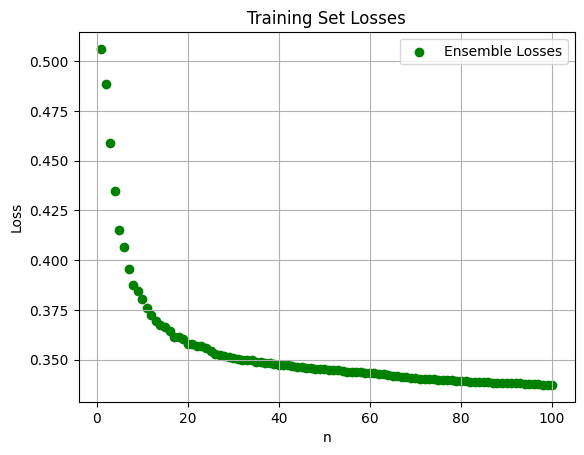

2024-10-10 14:30:10,218 - gradient_booster - INFO - Losses:
      n  ensemble_losses
0     1         0.499901
1     2         0.483232
2     3         0.455089
3     4         0.432848
4     5         0.415391
5     6         0.407437
6     7         0.398209
7     8         0.391264
8     9         0.389058
9    10         0.385937
10   11         0.382660
11   12         0.380219
12   13         0.378424
13   14         0.376904
14   15         0.376169
15   16         0.375011
16   17         0.372743
17   18         0.372618
18   19         0.372265
19   20         0.370407
20   21         0.370137
21   22         0.370026
22   23         0.369986
23   24         0.369720
24   25         0.368755
25   26         0.367953
26   27         0.367485
27   28         0.367073
28   29         0.366934
29   30         0.366706
30   31         0.366397
31   32         0.366246
32   33         0.366140
33   34         0.366220
34   35         0.366056
35   36         0.365967
36   37        

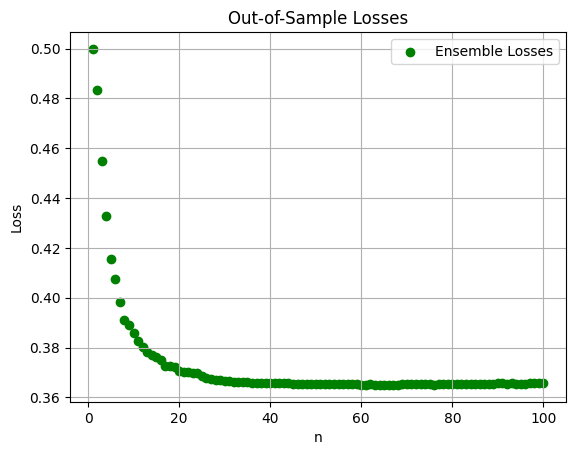

2024-10-10 14:30:10,471 - __main__ - INFO - Optimized number of trees: 68
2024-10-10 14:30:51,154 - gradient_booster - INFO - Losses:
      n  ensemble_losses
0     1         0.500441
1     2         0.483466
2     3         0.454502
3     4         0.431474
4     5         0.413365
5     6         0.404901
6     7         0.394851
7     8         0.387548
8     9         0.385103
9    10         0.381607
10   11         0.377816
11   12         0.374829
12   13         0.372588
13   14         0.370899
14   15         0.370022
15   16         0.368787
16   17         0.366418
17   18         0.366285
18   19         0.365786
19   20         0.363851
20   21         0.363567
21   22         0.363244
22   23         0.363100
23   24         0.362757
24   25         0.361760
25   26         0.361021
26   27         0.360613
27   28         0.360111
28   29         0.360029
29   30         0.359852
30   31         0.359697
31   32         0.359660
32   33         0.359519
33   34         

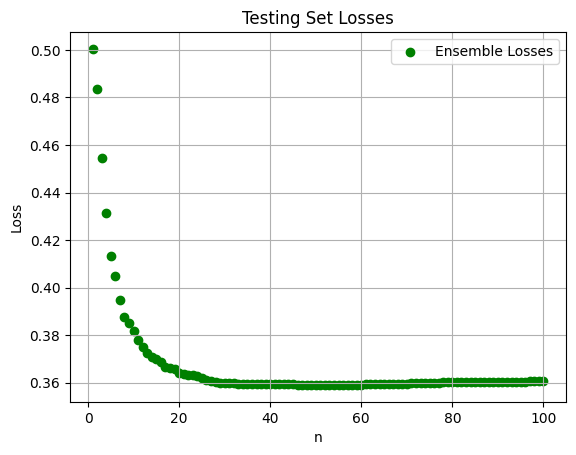

2024-10-10 14:31:21,048 - __main__ - INFO - Log-Loss: 0.3595


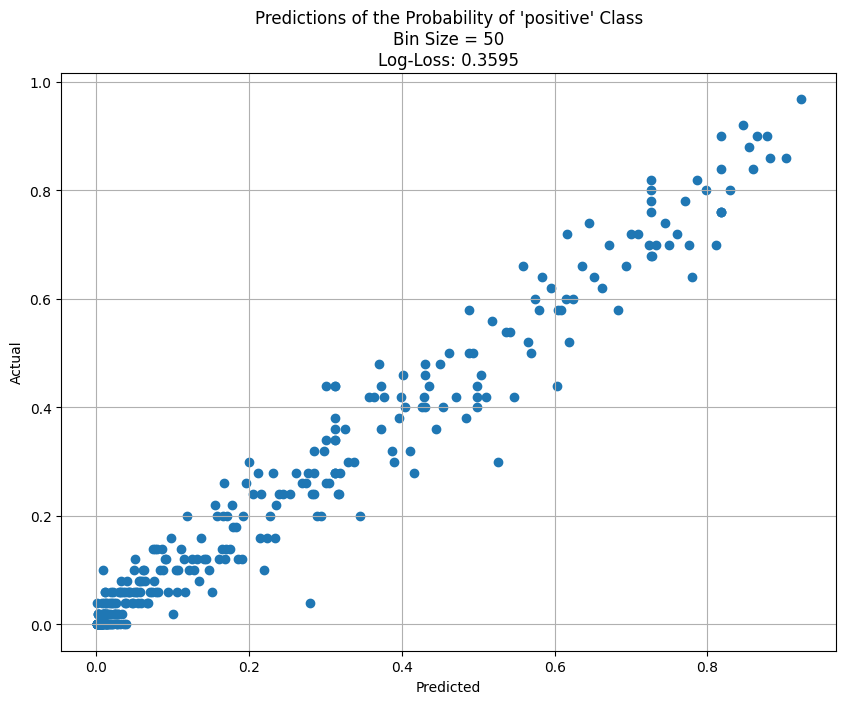

In [9]:
n_iter = 100
oos_frac = 0.2

tree_kwargs = {
    "split_method": "gain",
    "prior_method": "mle",
    "prior_alpha": [1.0, 1.0],
    "prior_cap": 100,
    "min_smooth_obs": 100,
    "min_prediction": 1e-6,
    "min_improvement": 1e-6,
    "max_level": 3,
    "predictors_to_ignore": 0.0,
    "write_log": False
}
gb_kwargs = {
    "n_iter": n_iter, 
    "learning_rate": 0.1, 
    "predictors_to_remove": 0.7, 
    "sampling": {"frac": 0.7, "sync": False, "replace": True},
    "random_state": 1234
}

train_ind = np.random.choice(
    learn_data.shape[0], 
    round((1.0 - oos_frac) * learn_data.shape[0]), 
    replace=False
)

train_data = learn_data.loc[train_ind, :]
train_data.reset_index(drop=True, inplace=True)
oos_data = learn_data.loc[~learn_data.index.isin(train_ind), :]
oos_data.reset_index(drop=True, inplace=True)

gb = GradientBooster(**{**gb_kwargs, **tree_kwargs})
gb.fit(X=train_data[PREDICTORS], y=train_data[OUTCOMES_COLS])

gb.plot_losses(X=None)
oss_loss_data = gb.plot_losses(
    X=oos_data[PREDICTORS], y=oos_data[OUTCOMES_COLS], title="Out-of-Sample Losses"
)

opt_n_trees = oss_loss_data.loc[oss_loss_data["ensemble_losses"].idxmin(), "n"]
logger.info(f"Optimized number of trees: {opt_n_trees}")

gb.plot_losses(X=test_data[PREDICTORS], y=test_data[OUTCOMES_COLS])

predictions = gb.predict_proba(X=test_data[PREDICTORS], n_iter_to_use=opt_n_trees) 
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 12:05:44,691 - gradient_booster - INFO - Losses:
      n  ensemble_losses
0     1         0.501332
1     2         0.485147
2     3         0.456041
3     4         0.432833
4     5         0.415573
5     6         0.408016
6     7         0.399084
7     8         0.392666
8     9         0.390177
9    10         0.386879
10   11         0.383469
11   12         0.380845
12   13         0.378904
13   14         0.377165
14   15         0.376194
15   16         0.375087
16   17         0.373151
17   18         0.373075
18   19         0.372888
19   20         0.371235
20   21         0.370976
21   22         0.370790
22   23         0.370646
23   24         0.370488
24   25         0.369913
25   26         0.369382
26   27         0.369037
27   28         0.368835
28   29         0.368858
29   30         0.368740
30   31         0.368557
31   32         0.368450
32   33         0.368365
33   34         0.368417
34   35         0.368392
35   36         0.368267
36   37        

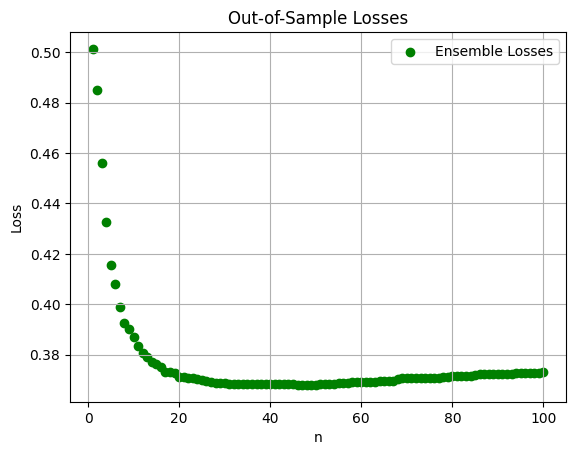

2024-10-10 12:05:44,941 - __main__ - INFO - Optimized number of trees: 50
2024-10-10 12:06:27,606 - gradient_booster - INFO - Losses:
      n  ensemble_losses
0     1         0.499704
1     2         0.483196
2     3         0.453677
3     4         0.429923
4     5         0.411789
5     6         0.404236
6     7         0.394732
7     8         0.388080
8     9         0.385567
9    10         0.382099
10   11         0.378365
11   12         0.375622
12   13         0.373353
13   14         0.371584
14   15         0.370576
15   16         0.369454
16   17         0.367131
17   18         0.367010
18   19         0.366551
19   20         0.364462
20   21         0.364213
21   22         0.363850
22   23         0.363588
23   24         0.363402
24   25         0.362403
25   26         0.361559
26   27         0.361013
27   28         0.360615
28   29         0.360596
29   30         0.360337
30   31         0.360074
31   32         0.359979
32   33         0.359894
33   34         

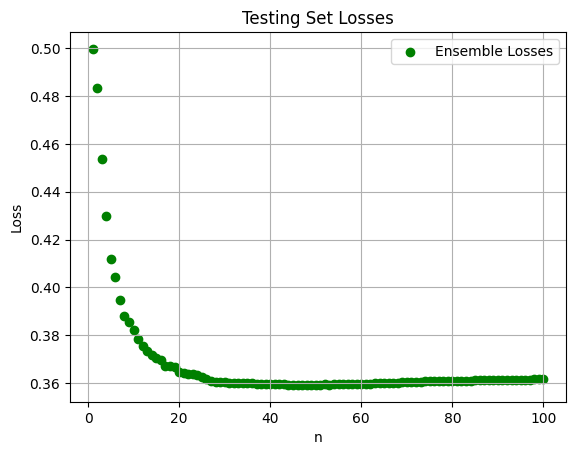

2024-10-10 12:06:46,996 - __main__ - INFO - Log-Loss: 0.3592


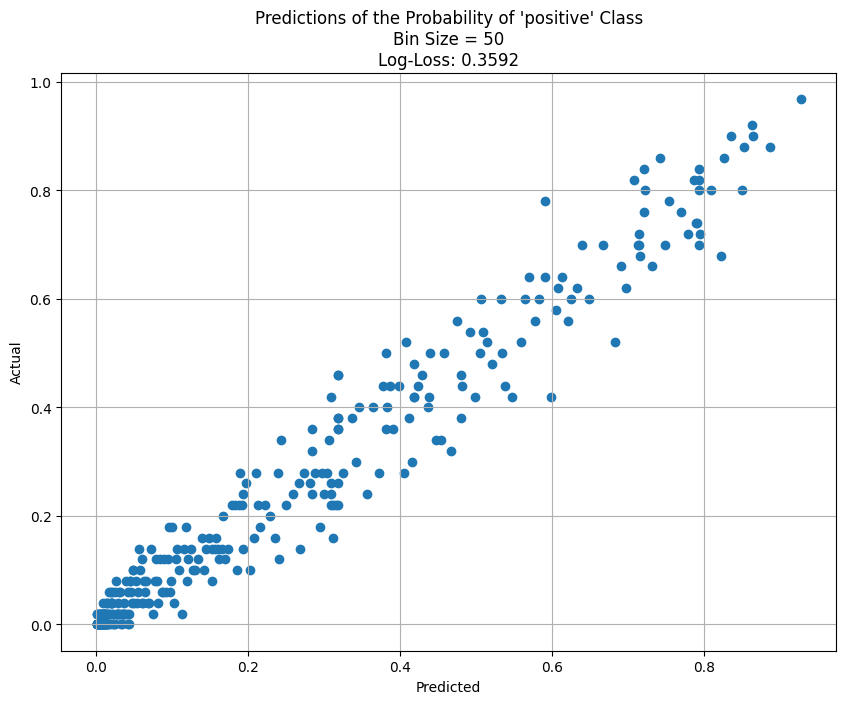

In [11]:
oss_loss_data = gb.plot_losses(
    X=oos_data[PREDICTORS], y=oos_data[OUTCOMES_COLS], title="Out-of-Sample Losses"
)

opt_n_trees = oss_loss_data.loc[oss_loss_data["ensemble_losses"].idxmin(), "n"]
logger.info(f"Optimized number of trees: {opt_n_trees}")

gb.plot_losses(X=test_data[PREDICTORS], y=test_data[OUTCOMES_COLS])

predictions = gb.predict_proba(X=test_data[PREDICTORS], n_iter_to_use=opt_n_trees) 
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

In [10]:
from sklearn.ensemble import (
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier, 
    RandomForestClassifier
)
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.tree import DecisionTreeClassifier

# Native Support for Categorical Features

2024-10-10 14:32:50,776 - __main__ - INFO - Log-Loss: 0.3581


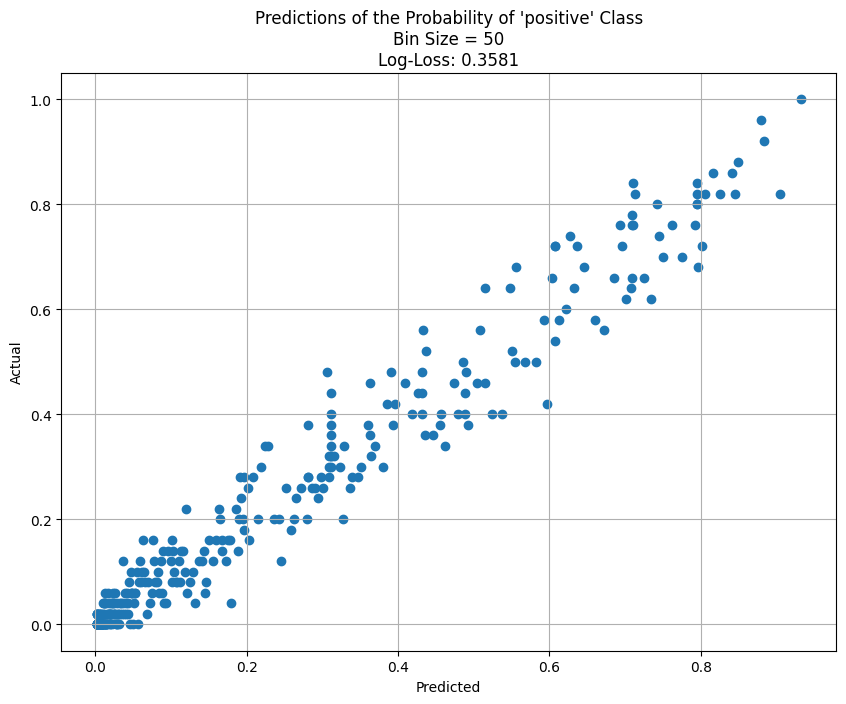

In [11]:
clf = HistGradientBoostingClassifier(categorical_features=PREDICTORS, random_state=1234)
clf.fit(learn_data[PREDICTORS], learn_data["positive"])

positive_estimates = np.clip(clf.predict_proba(test_data[PREDICTORS])[:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

# Target Encoding of Categorical Features

In [18]:
raw_data_cat_cols = [
    c for c in raw_learn_data.columns if c not in OUTCOMES_COLS
]

encoder = TargetEncoder(target_type="binary", random_state=1234)
learn_data = pd.concat(
    [      
        pd.DataFrame(
            encoder.fit_transform(raw_learn_data[raw_data_cat_cols], raw_learn_data["positive"]),
            columns=raw_data_cat_cols
        ),
        raw_learn_data[OUTCOMES_COLS]
    ],
    axis=1
)
test_data = pd.concat(
    [
        pd.DataFrame(
            encoder.transform(raw_test_data[raw_data_cat_cols]), 
            columns=raw_data_cat_cols
        ),
        raw_test_data[OUTCOMES_COLS]
    ],
    axis=1
)
print(learn_data.head())

predictors = [c for c in learn_data.columns if c not in OUTCOMES_COLS]

   workclass  education  marital-status  occupation  relationship      race  \
0   0.271204   0.417814        0.042765    0.134619      0.099860  0.256771   
1   0.287912   0.410472        0.446977    0.481165      0.449287  0.255785   
2   0.218595   0.163314        0.102555    0.063784      0.104399  0.255824   
3   0.218439   0.052630        0.445253    0.072767      0.446061  0.130816   
4   0.218514   0.417814        0.450473    0.445997      0.477557  0.119330   

        sex  native-country  negative  positive  
0  0.306195        0.245611         1         0  
1  0.306368        0.245597         1         0  
2  0.305003        0.246244         1         0  
3  0.305484        0.245823         1         0  
4  0.108827        0.259997         1         0  


2024-10-10 07:18:55,924 - __main__ - INFO - Log-Loss: 0.3707


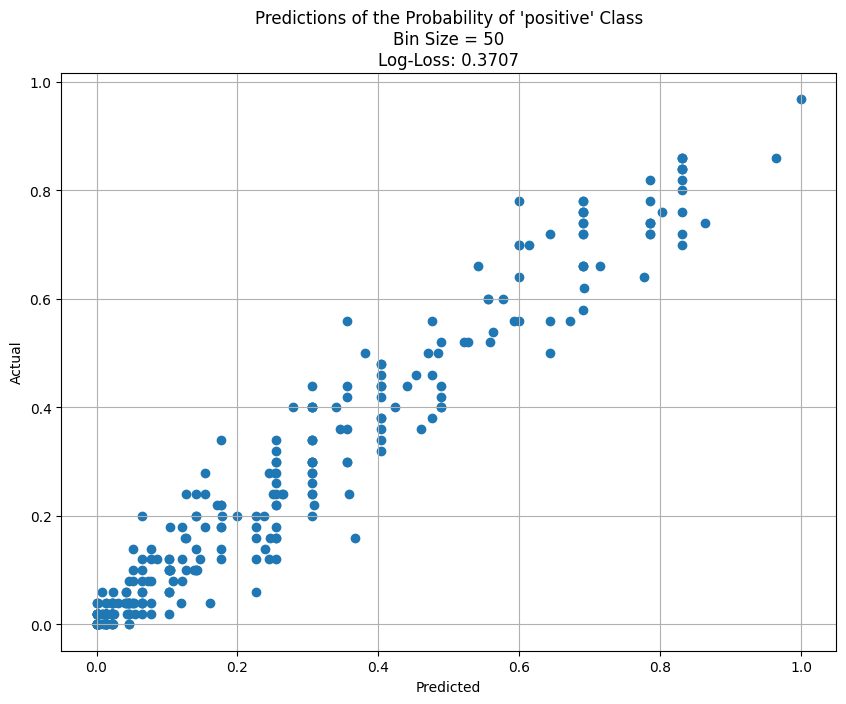

In [19]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=20, criterion="log_loss", random_state=1234)
clf.fit(learn_data[predictors], learn_data[OUTCOMES_COLS])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[1][:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:19:25,123 - __main__ - INFO - Log-Loss: 0.3605


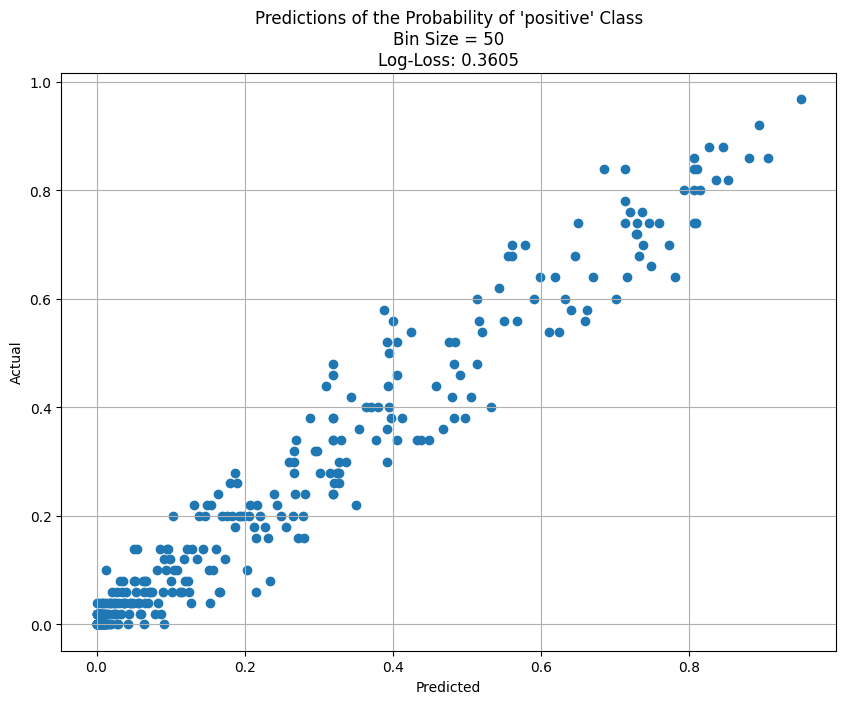

In [20]:
clf = RandomForestClassifier(max_depth=15, criterion="log_loss", random_state=1234)
clf.fit(learn_data[predictors], learn_data[OUTCOMES_COLS])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[1][:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:19:39,388 - __main__ - INFO - Log-Loss: 0.3572


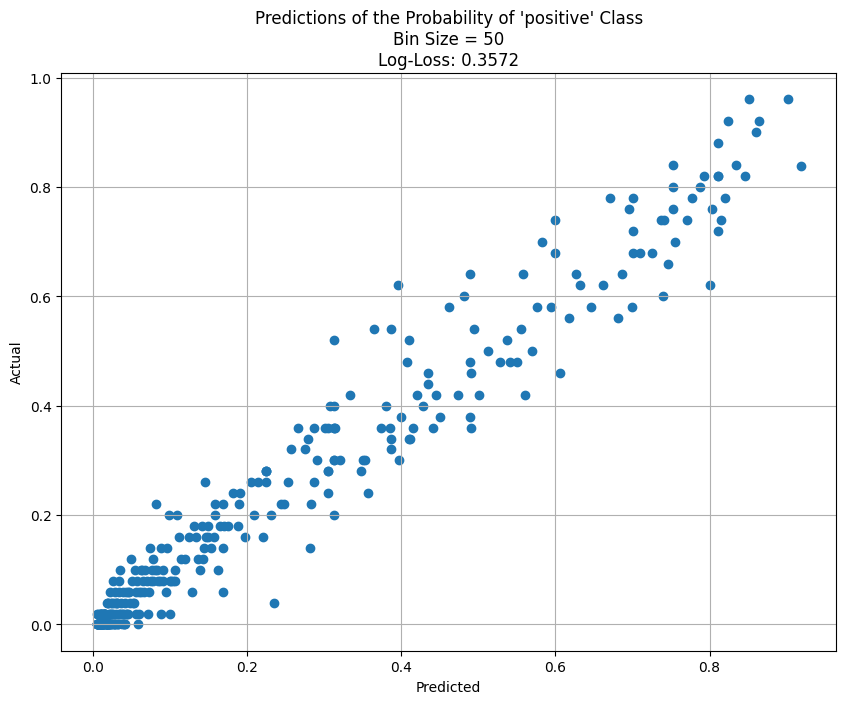

In [21]:
clf = GradientBoostingClassifier(random_state=1234)
clf.fit(learn_data[predictors], learn_data["positive"])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:20:00,205 - __main__ - INFO - Log-Loss: 0.3565


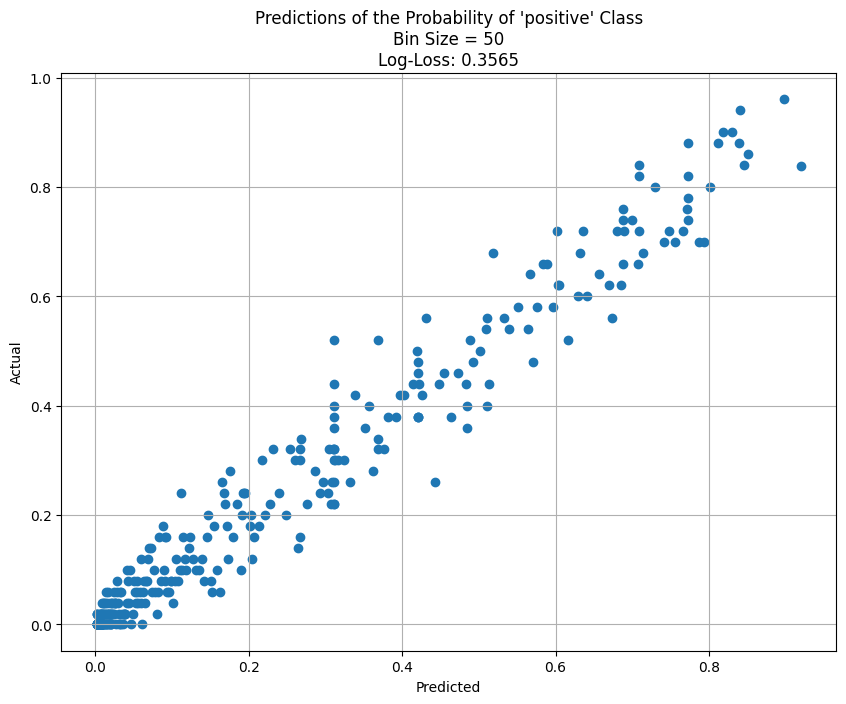

In [22]:
clf = HistGradientBoostingClassifier(categorical_features=None, random_state=1234)
clf.fit(learn_data[predictors], learn_data["positive"])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

# One-Hot Encoding of Categorical Features

In [23]:
raw_data_cat_cols = [
    c for c in raw_learn_data.columns if c not in OUTCOMES_COLS
]

encoder = OneHotEncoder(handle_unknown="ignore")
learn_data = pd.concat(
    [
        pd.DataFrame(
            encoder.fit_transform(raw_learn_data[raw_data_cat_cols]).toarray(), 
            columns=encoder.get_feature_names_out()
        ),
        raw_learn_data[OUTCOMES_COLS]
    ],
    axis=1
)
test_data = pd.concat(
    [
        pd.DataFrame(
            encoder.transform(raw_test_data[raw_data_cat_cols]).toarray(), 
            columns=encoder.get_feature_names_out()
        ),
        raw_test_data[OUTCOMES_COLS]
    ],
    axis=1
)
print(learn_data.head())

predictors = [c for c in learn_data.columns if c not in OUTCOMES_COLS]

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                    0.0                  0.0                     0.0   
1                    0.0                  0.0                     0.0   
2                    0.0                  0.0                     0.0   
3                    0.0                  0.0                     0.0   
4                    0.0                  0.0                     0.0   

   workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                0.0                     0.0                         0.0   
1                0.0                     0.0                         1.0   
2                1.0                     0.0                         0.0   
3                1.0                     0.0                         0.0   
4                1.0                     0.0                         0.0   

   workclass_State-gov  workclass_Without-pay  workclass_nan  education_10th  \
0                  1.0  

2024-10-10 07:20:12,741 - __main__ - INFO - Log-Loss: 0.3773


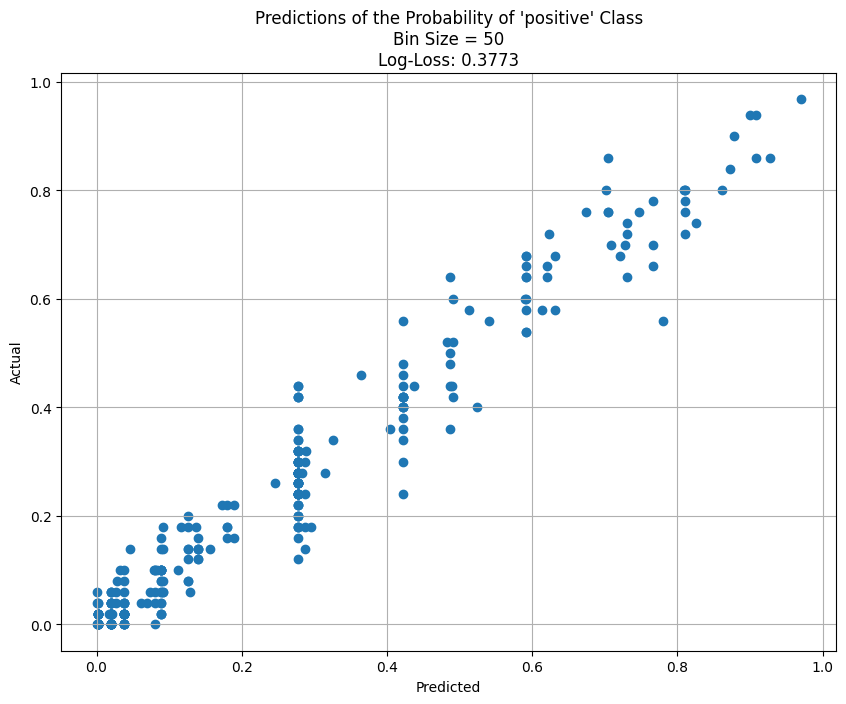

In [24]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=20, criterion="log_loss", random_state=1234)
clf.fit(learn_data[predictors], learn_data[OUTCOMES_COLS])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[1][:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:20:33,063 - __main__ - INFO - Log-Loss: 0.3631


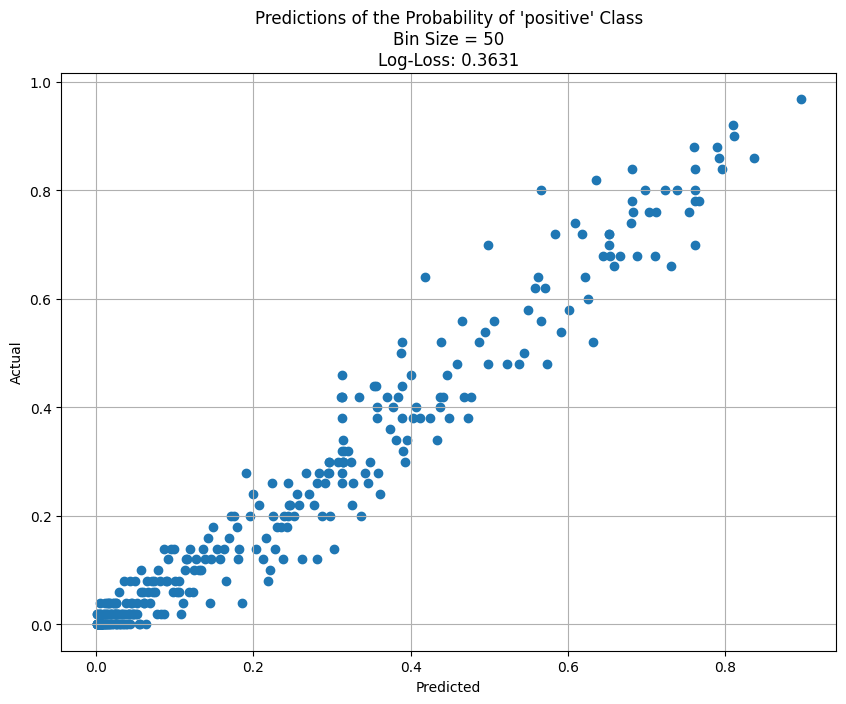

In [25]:
clf = RandomForestClassifier(max_depth=15, criterion="log_loss", random_state=1234)
clf.fit(learn_data[predictors], learn_data[OUTCOMES_COLS])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[1][:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:20:58,108 - __main__ - INFO - Log-Loss: 0.3606


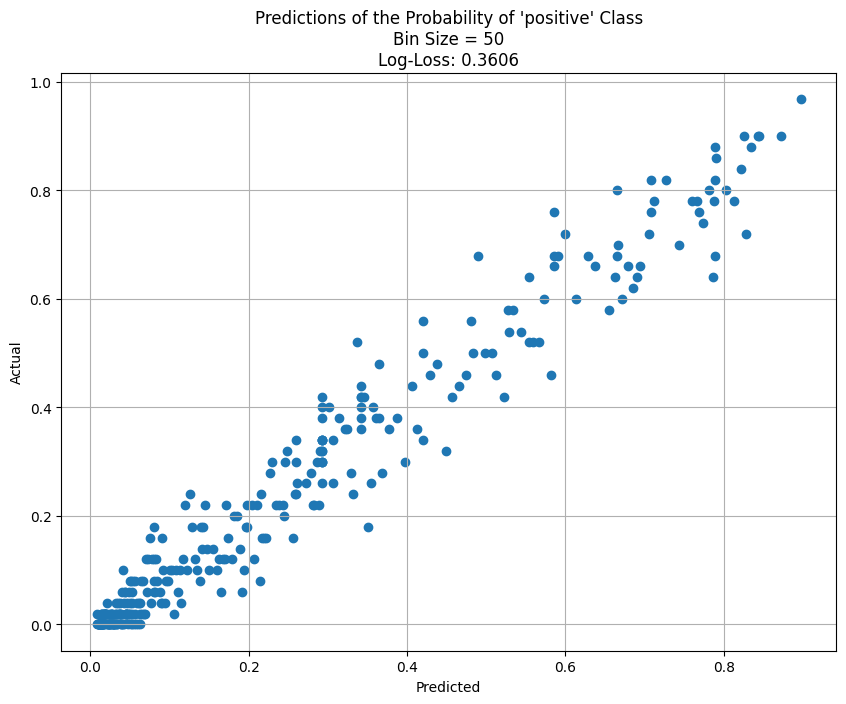

In [26]:
clf = GradientBoostingClassifier(random_state=1234)
clf.fit(learn_data[predictors], learn_data["positive"])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:21:13,418 - __main__ - INFO - Log-Loss: 0.3587


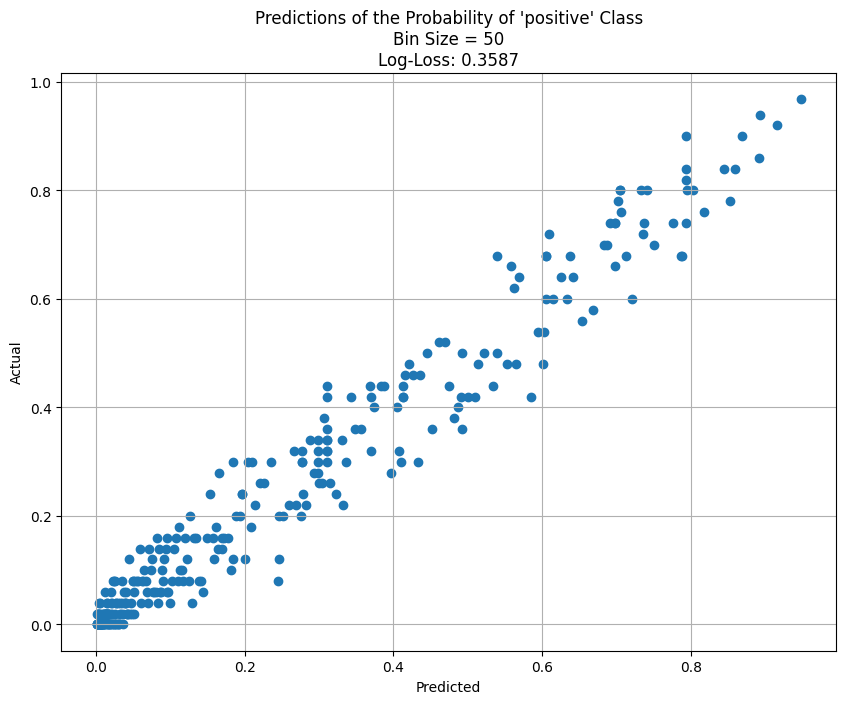

In [27]:
clf = HistGradientBoostingClassifier(categorical_features=None, random_state=1234)
clf.fit(learn_data[predictors], learn_data["positive"])

positive_estimates = np.clip(clf.predict_proba(test_data[predictors])[:, 1], 1e-6, 1 - 1e-6)
predictions = pd.DataFrame({"negative": 1 - positive_estimates, "positive": positive_estimates})
loss = get_log_loss(predictions, test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

# PySpark Models

In [28]:
import pyspark.sql.functions as F
from pyspark.ml.classification import (
    DecisionTreeClassificationModel,
    DecisionTreeClassifier,
    GBTClassificationModel,
    GBTClassifier,
    LogisticRegression,
    LogisticRegressionModel,
    RandomForestClassificationModel,
    RandomForestClassifier,
)
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.types import (
    DateType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
    TimestampType
)

get_failure_probability = F.udf(lambda v: float(v[0]), FloatType())
get_success_probability = F.udf(lambda v: float(v[1]), FloatType())

In [29]:
raw_learn_data_ps = spark.createDataFrame(raw_learn_data)
raw_test_data_ps = spark.createDataFrame(raw_test_data)

In [30]:
string_indexes = [f"{c}_ind" for c in PREDICTORS]
string_indexer = StringIndexer(
    inputCols=PREDICTORS, outputCols=string_indexes, handleInvalid="keep"
)
string_indexer_model = string_indexer.fit(raw_learn_data_ps)
learn_data_ps = string_indexer_model.transform(raw_learn_data_ps)
test_data_ps = string_indexer_model.transform(raw_test_data_ps)

vector_assembler = VectorAssembler(
    inputCols=string_indexes, outputCol="features", handleInvalid="keep"
)
learn_data_ps = vector_assembler.transform(learn_data_ps)
test_data_ps = vector_assembler.transform(test_data_ps)

# remove the individual predictor columns
learn_data_ps = learn_data_ps.drop(*(PREDICTORS + string_indexes))
test_data_ps = test_data_ps.drop(*(PREDICTORS + string_indexes))

2024-10-10 07:37:29,286 - __main__ - INFO - Log-Loss: 0.3890                    


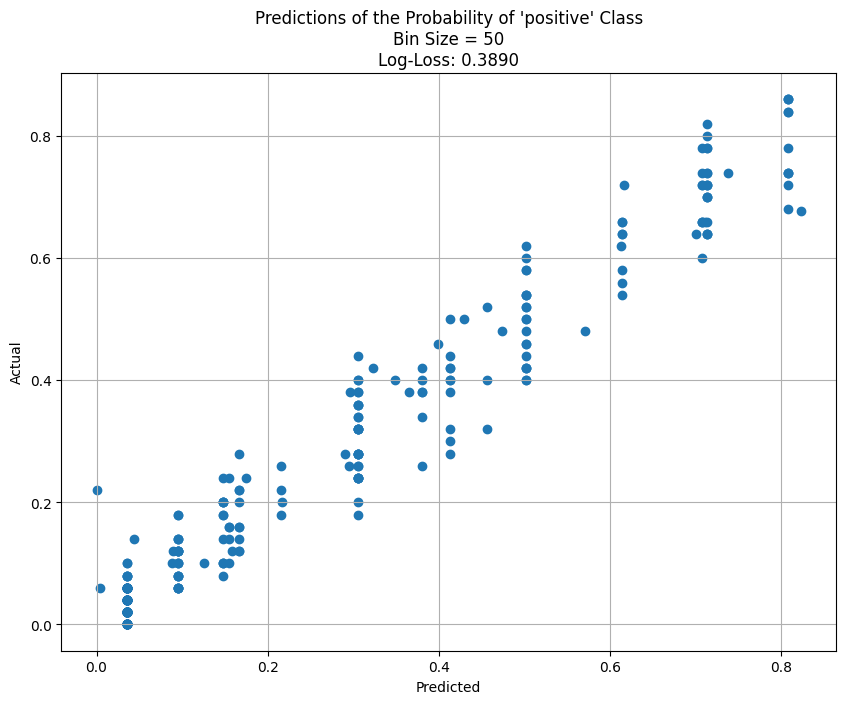

In [42]:
classifier = DecisionTreeClassifier(
    featuresCol="features", 
    labelCol="positive", 
    impurity="entropy", 
    maxBins=50, 
    maxDepth=7,
    minInstancesPerNode=20
)
model = classifier.fit(learn_data_ps)

predictions = (
    model
    .transform(test_data_ps)
    .select(
        get_success_probability("probability").alias("positive")
    )
    .toPandas()
)
predictions["positive"] = np.clip(predictions["positive"], 1e-6, 1 - 1e-6)
predictions["negative"] = 1.0 - predictions["positive"]
predictions = predictions[["negative", "positive"]]

loss = get_log_loss(predictions, raw_test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, raw_test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:40:57,097 - __main__ - INFO - Log-Loss: 0.3605                    


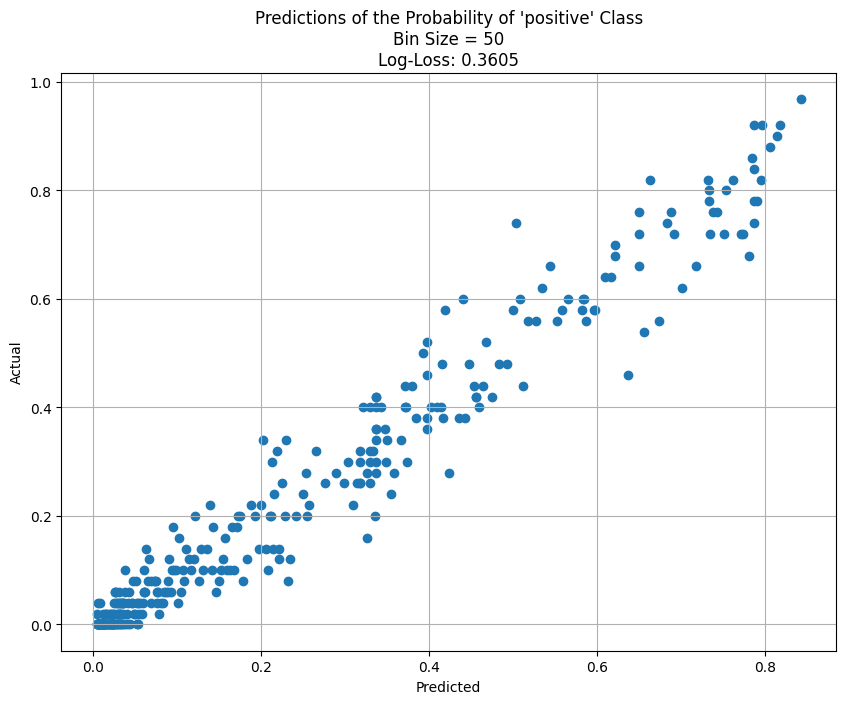

In [43]:
classifier = RandomForestClassifier(
    featuresCol="features", 
    labelCol="positive", 
    numTrees=100, 
    impurity="entropy", 
    maxBins=50, 
    maxDepth=10
)
model = classifier.fit(learn_data_ps)

predictions = (
    model
    .transform(test_data_ps)
    .select(
        get_success_probability("probability").alias("positive")
    )
    .toPandas()
)
predictions["positive"] = np.clip(predictions["positive"], 1e-6, 1 - 1e-6)
predictions["negative"] = 1.0 - predictions["positive"]
predictions = predictions[["negative", "positive"]]

loss = get_log_loss(predictions, raw_test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, raw_test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()

2024-10-10 07:42:25,048 - __main__ - INFO - Log-Loss: 0.3596                    


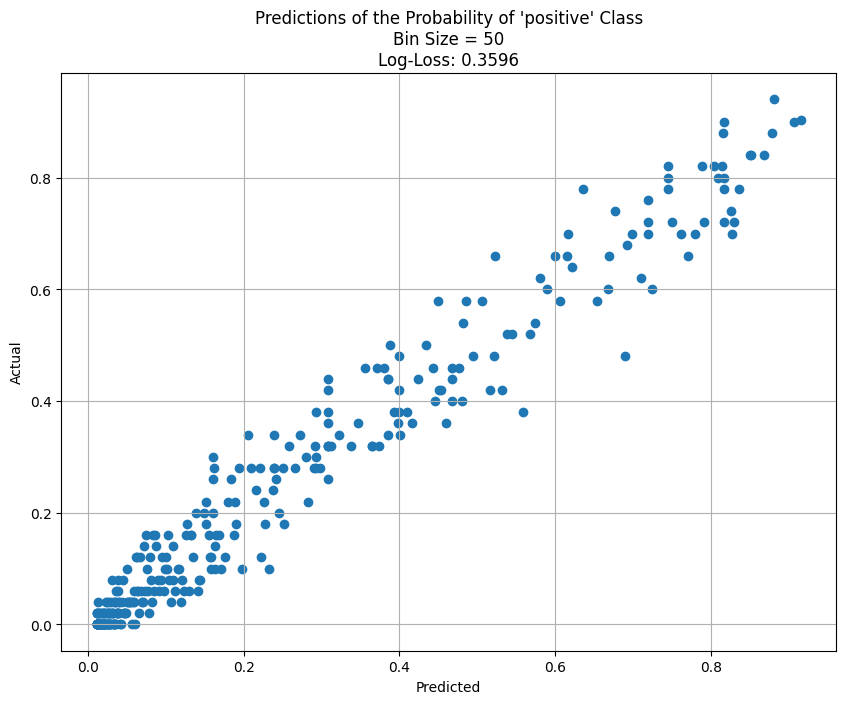

In [ ]:
classifier = GBTClassifier(
    featuresCol="features", 
    labelCol="positive", 
    maxIter=100,
    stepSize=0.1,
    maxBins=50, 
    maxDepth=3
)
model = classifier.fit(learn_data_ps)

predictions = (
    model
    .transform(test_data_ps)
    .select(
        get_success_probability("probability").alias("positive")
    )
    .toPandas()
)
predictions["positive"] = np.clip(predictions["positive"], 1e-6, 1 - 1e-6)
predictions["negative"] = 1.0 - predictions["positive"]
predictions = predictions[["negative", "positive"]]

loss = get_log_loss(predictions, raw_test_data[OUTCOMES_COLS])
logger.info(f"Log-Loss: {loss:.4f}")

f, plot_data = plot_performance_chart(
    predictions, raw_test_data[OUTCOMES_COLS], "positive", 50, loss
)
f.show()